## Configurations for Colab

In [ ]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !apt install python-opengl
    !apt install ffmpeg
    !apt install xvfb
    !pip install PyVirtualDisplay==3.0
    !pip install gymnasium==0.28.1
    !pip install pytorch-tcn
    from pyvirtualdisplay import Display

    # Start virtual display
    dis = Display(visible=0, size=(400, 400))
    dis.start()

# 08. Rainbow

[M. Hessel et al., "Rainbow: Combining Improvements in Deep Reinforcement Learning." arXiv preprint arXiv:1710.02298, 2017.](https://arxiv.org/pdf/1710.02298.pdf)

We will integrate all the following seven components into a single integrated agent, which is called Rainbow!

1. DQN
2. Double DQN
3. Prioritized Experience Replay
4. Dueling Network
5. Noisy Network
6. Categorical DQN
7. N-step Learning

This method shows an impressive performance on the Atari 2600 benchmark, both in terms of data efficiency and final performance.

![rainbow](https://user-images.githubusercontent.com/14961526/60591412-61748100-9dd9-11e9-84fb-076c7a61fbab.png)

However, the integration is not so simple because some of components are not independent each other, so we will look into a number of points that people especailly feel confused.

1. Noisy Network <-> Dueling Network
2. Dueling Network <-> Categorical DQN
3. Categorical DQN <-> Double DQN

In [ ]:
import math
import os
import random
from collections import deque
from typing import Deque, Dict, List, Tuple

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm
# download segment tree module
# if IN_COLAB:
#     !wget https://raw.githubusercontent.com/curt-park/rainbow-is-all-you-need/master/segment_tree.py
import pickle
from Agent.segment_tree import MinSegmentTree, SumSegmentTree
from torch.optim.lr_scheduler import ExponentialLR


from datetime import datetime

In [ ]:
import sys
sys.path.append('/home/ece/anaconda3/bin/project-RL304/project-RL304/')
# sys.path.append('/content/project-RL304/Agent')

from Agent.env_test import CustomEnv

## Replay buffer

Same as the basic N-step buffer.

(Please see *01.dqn.ipynb*, *07.n_step_learning.ipynb* for detailed description about the basic (n-step) replay buffer.)

In [ ]:
class ReplayBuffer:
    """A simple numpy replay buffer."""

    def __init__(
        self,
        obs_dim: Tuple[int],
        size: int,
        batch_size: int = 32,
        n_step: int = 1,
        gamma: float = 0.99
    ):
        self.obs_buf = np.zeros([size, *obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, *obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

        # for N-step Learning
        self.n_step_buffer = deque(maxlen=n_step)
        self.n_step = n_step
        self.gamma = gamma

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        transition = (obs, act, rew, next_obs, done)
        self.n_step_buffer.append(transition)

        # single step transition is not ready
        if len(self.n_step_buffer) < self.n_step:
            return ()

        # make a n-step transition
        rew, next_obs, done = self._get_n_step_info(
            self.n_step_buffer, self.gamma
        )
        obs, act = self.n_step_buffer[0][:2]

        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

        return self.n_step_buffer[0]

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)

        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            # for N-step Learning
            indices=idxs,
        )

    def sample_batch_from_idxs(
        self, idxs: np.ndarray
    ) -> Dict[str, np.ndarray]:
        # for N-step Learning
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
        )

    def _get_n_step_info(
        self, n_step_buffer: Deque, gamma: float
    ) -> Tuple[np.int64, np.ndarray, bool]:
        """Return n step rew, next_obs, and done."""
        # info of the last transition
        rew, next_obs, done = n_step_buffer[-1][-3:]

        for transition in reversed(list(n_step_buffer)[:-1]):
            r, n_o, d = transition[-3:]

            rew = r + gamma * rew * (1 - d)
            next_obs, done = (n_o, d) if d else (next_obs, done)

        return rew, next_obs, done

    def __len__(self) -> int:
        return self.size

## Prioritized replay Buffer

`store` method returns boolean in order to inform if a N-step transition has been generated.

(Please see *02.per.ipynb* for detailed description about PER.)

In [ ]:
class PrioritizedReplayBuffer(ReplayBuffer):
    """Prioritized Replay buffer.

    Attributes:
        max_priority (float): max priority
        tree_ptr (int): next index of tree
        alpha (float): alpha parameter for prioritized replay buffer
        sum_tree (SumSegmentTree): sum tree for prior
        min_tree (MinSegmentTree): min tree for min prior to get max weight

    """

    def __init__(
        self,
        obs_dim: int,
        size: int,
        batch_size: int = 32,
        alpha: float = 0.6,
        n_step: int = 1,
        gamma: float = 0.99,
    ):
        """Initialization."""
        assert alpha >= 0

        super(PrioritizedReplayBuffer, self).__init__(
            obs_dim, size, batch_size, n_step, gamma
        )
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha

        # capacity must be positive and a power of 2.
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)

    def store(
        self,
        obs: np.ndarray,
        act: int,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
    ) -> Tuple[np.ndarray, np.ndarray, float, np.ndarray, bool]:
        """Store experience and priority."""
        transition = super().store(obs, act, rew, next_obs, done)

        if transition:
            self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
            self.tree_ptr = (self.tree_ptr + 1) % self.max_size

        return transition

    def sample_batch(self, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        assert len(self) >= self.batch_size
        assert beta > 0

        indices = self._sample_proportional()

        obs = self.obs_buf[indices]
        next_obs = self.next_obs_buf[indices]
        acts = self.acts_buf[indices]
        rews = self.rews_buf[indices]
        done = self.done_buf[indices]
        weights = np.array([self._calculate_weight(i, beta) for i in indices])

        return dict(
            obs=obs,
            next_obs=next_obs,
            acts=acts,
            rews=rews,
            done=done,
            weights=weights,
            indices=indices,
        )

    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)

        for idx, priority in zip(indices, priorities):
            assert priority > 0
            assert 0 <= idx < len(self)

            self.sum_tree[idx] = priority ** self.alpha
            self.min_tree[idx] = priority ** self.alpha

            self.max_priority = max(self.max_priority, priority)

    def _sample_proportional(self) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / self.batch_size

        for i in range(self.batch_size):
            a = segment * i
            b = segment * (i + 1)
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)

        return indices

    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)

        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight

        return weight

## Noisy Layer

Please see *05.noisy_net.ipynb* for detailed description.

**References:**

- https://github.com/higgsfield/RL-Adventure/blob/master/5.noisy%20dqn.ipynb
- https://github.com/Kaixhin/Rainbow/blob/master/model.py

In [ ]:
class NoisyLinear(nn.Module):
    """Noisy linear module for NoisyNet.



    Attributes:
        in_features (int): input size of linear module
        out_features (int): output size of linear module
        std_init (float): initial std value
        weight_mu (nn.Parameter): mean value weight parameter
        weight_sigma (nn.Parameter): std value weight parameter
        bias_mu (nn.Parameter): mean value bias parameter
        bias_sigma (nn.Parameter): std value bias parameter

    """

    def __init__(
        self,
        in_features: int,
        out_features: int,
        std_init: float = 0.5,
    ):
        """Initialization."""
        super(NoisyLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.

        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )

    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.randn(size)

        return x.sign().mul(x.abs().sqrt())

## NoisyNet + DuelingNet + Categorical DQN

#### NoisyNet + DuelingNet

NoisyLinear is employed for the last two layers of advantage and value layers. The noise should be reset at evey update step.

#### DuelingNet + Categorical DQN

The dueling network architecture is adapted for use with return distributions. The network has a shared representation, which is then fed into a value stream with atom_size outputs, and into an advantage stream with atom_size × out_dim outputs. For each atom, the value and advantage streams are aggregated, as in dueling DQN, and then passed through a softmax layer to obtain the normalized parametric distributions used to estimate the returns’ distributions.

```
        advantage = self.advantage_layer(adv_hid).view(-1, self.out_dim, self.atom_size)
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)
        
        dist = F.softmax(q_atoms, dim=-1)
```

(Please see *04.dueling.ipynb*, *05.noisy_net.ipynb*, *06.categorical_dqn.ipynb* for detailed description of each component's network architecture.)

In [ ]:
import torch
import torch.nn as nn
from pytorch_tcn import TCN

class Network(nn.Module):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        atom_size: int,
        support: torch.Tensor
    ):
        """Initialization."""
        super(Network, self).__init__()

        self.support = support
        self.out_dim = out_dim
        self.atom_size = atom_size

        # set TCN layers
        self.tcn = TCN(num_inputs=33, num_channels=[64, 64, 64, 128, 128, 128, 128, 256, 256, 256, 256, 256, 256, 512, 512, 512], kernel_size=12, dropout=0.1, activation="relu", use_skip_connections=True)

        # bottle neck
        self.Bottleneck = nn.Sequential(

            #  Bottle neck
            nn.Conv1d(512, 128, kernel_size=24, padding=1),  # Maintain spatial dimensions
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
        )

        # Flatten layer
        self.flatten = nn.Flatten(1, 2)


        # Linear layers
        self.Linear_layers = nn.Sequential(
            nn.Linear(2688, 2048),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
        )

        # set advantage layer
        self.advantage_hidden_layer = NoisyLinear(64, 64)
        self.advantage_layer = NoisyLinear(64, out_dim * atom_size)

        # set value layer
        self.value_hidden_layer = NoisyLinear(64, 64)
        self.value_layer = NoisyLinear(64, atom_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation."""
        dist = self.dist(x)
        q = torch.sum(dist * self.support, dim=2)

        return q

    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms."""
        # Apply TCN layers
        x = self.tcn(x.permute(0, 2, 1))  # input shape: (batch_size, sequence_length, input_size)
        x = self.Bottleneck(x)

        # Flatten
        x = self.flatten(x)

        # Linear layers
        linear = self.Linear_layers(x)

        # Advantage and value layers
        adv_hid = F.relu(self.advantage_hidden_layer(linear))
        val_hid = F.relu(self.value_hidden_layer(linear))
        advantage = self.advantage_layer(adv_hid).view(-1, self.out_dim, self.atom_size)
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)

        # Softmax to get distribution
        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans

        return dist

    def reset_noise(self):
        """Reset all noisy layers."""
        self.advantage_hidden_layer.reset_noise()
        self.advantage_layer.reset_noise()
        self.value_hidden_layer.reset_noise()
        self.value_layer.reset_noise()


/home/ece/anaconda3/lib/python3.7/site-packages/pytorch_tcn/tcn.py:16: UserWarning: 
        The deprecated weight_norm from torch.nn.utils.weight_norm was imported.
        Update your PyTorch version to get rid of this warning.
        
  """


In [ ]:
model = Network(1, 3, 51, torch.tensor([i for i in range(-20, 21)]))

In [ ]:
model.cuda()
tcn = model.tcn(torch.rand(1, 33, 42).cuda())
Bottleneck = model.Bottleneck(tcn)
flatten = model.flatten(Bottleneck)

In [ ]:
model.cuda()
model.tcn(torch.rand(1, 33, 42).cuda()).shape

torch.Size([1, 512, 42])

In [ ]:
model.Bottleneck(tcn).shape

torch.Size([1, 128, 21])

In [ ]:
model.flatten(Bottleneck).shape

torch.Size([1, 2688])

In [ ]:

model.Linear_layers(flatten).shape

torch.Size([1, 64])

## Fine-tune 1:

In [ ]:
class Fine_tune_1(Network):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        atom_size: int,
        support: torch.Tensor
    ):
        super().__init__(in_dim, out_dim, atom_size, support)

        # Linear layers
        self.Linear_layers = nn.Sequential(
            nn.Linear(5120, 4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
        )


In [ ]:
model = Fine_tune_1(1, 3, 51, torch.tensor([i for i in range(-20, 21)]))

In [ ]:
model.cuda()
conv_output = model.Convolution_1(torch.rand(1, 33, 42).cuda())
conv2_output = model.Convolution_2(conv_output)
flattened_output = model.flatten(conv2_output)
model.Linear_layers(flattened_output).shape

AttributeError: 'Fine_tune_1' object has no attribute 'Convolution_1'

In [ ]:
model.Convolution_1(torch.rand(1, 33, 42).cuda()).shape

torch.Size([1, 128, 3])

In [ ]:
model.Convolution_2(conv_output).shape

torch.Size([1, 128, 3])

# Fine-tune 2:

In [ ]:
class Fine_tune_2(Fine_tune_1):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        atom_size: int,
        support: torch.Tensor
    ):
        super().__init__(in_dim, out_dim, atom_size, support)
        self.Convolution_3 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=512, kernel_size=3, padding=1),  # Maintain spatial dimensions
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Conv1d(512, 1024, kernel_size=3, padding=1),  # Maintain spatial dimensions
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Conv1d(1024, 1536, kernel_size=3, padding=1),#, dilation=2),  # Maintain spatial dimensions
            nn.BatchNorm1d(1536),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            #  Bottle neck
            nn.Conv1d(1536, 128, kernel_size=1, padding=1),  # Maintain spatial dimensions
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )

        # self.Linear_layers = nn.Sequential(

        #     nn.Linear(640, 512),
        #     nn.ReLU(),

        #     nn.Linear(512, 384),
        #     nn.ReLU(),

        #     nn.Linear(384, 256),
        #     nn.ReLU(),

        #     nn.Linear(256, 128),
        #     nn.ReLU(),

        #     nn.Linear(128, 64),
        #     nn.ReLU(),

        # )

    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms."""
        x = x.permute(0, 2, 1)
        Conv_1 = self.Convolution_1(x) # [batch_size, 42, 128]
        Conv_2 = self.Convolution_2(Conv_1)
        conv_3 = self.Convolution_3(Conv_2)

        linear = self.flatten(conv_3)
        linear = self.Linear_layers(linear)
        # feature = torch.sum(feature, dim=1, keepdim=False) # [batch_size, 128]
        adv_hid = F.relu(self.advantage_hidden_layer(linear))
        val_hid = F.relu(self.value_hidden_layer(linear))

        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size
        )
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)

        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans

        return dist

In [ ]:
model = Fine_tune_2(1, 3, 51, torch.tensor([i for i in range(-20, 21)]))

In [ ]:
model.cuda()
conv_output = model.Convolution_1(torch.rand(1, 33, 42).cuda())
conv2_output = model.Convolution_2(conv_output)
flattened_output = model.flatten(conv2_output)
model.Linear_layers(flattened_output).shape

torch.Size([1, 64])

In [ ]:
model.Convolution_1(torch.rand(1, 33, 42).cuda()).shape

torch.Size([1, 128, 3])

# Fine-tune 3:

In [ ]:
class Fine_tune_3(Fine_tune_2):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        atom_size: int,
        support: torch.Tensor
    ):
        super().__init__(in_dim, out_dim, atom_size, support)
        self.Convolution_4 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=512, kernel_size=3, padding=1),  # Maintain spatial dimensions
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Conv1d(512, 1024, kernel_size=3, padding=1),  # Maintain spatial dimensions
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Conv1d(1024, 1536, kernel_size=3, padding=1),#, dilation=2),  # Maintain spatial dimensions
            nn.BatchNorm1d(1536),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            #  Bottle neck
            nn.Conv1d(1536, 128, kernel_size=1, padding=1),  # Maintain spatial dimensions
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )

    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms."""
        x = x.permute(0, 2, 1)
        Conv_1 = self.Convolution_1(x) # [batch_size, 42, 128]
        Conv_2 = self.Convolution_2(Conv_1)
        Conv_3 = self.Convolution_3(Conv_2)
        Conv_4 = self.Convolution_4(Conv_3)

        linear = self.flatten(Conv_4)
        linear = self.Linear_layers(linear)
        # feature = torch.sum(feature, dim=1, keepdim=False) # [batch_size, 128]
        adv_hid = F.relu(self.advantage_hidden_layer(linear))
        val_hid = F.relu(self.value_hidden_layer(linear))

        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size
        )
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)

        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans

        return dist

In [ ]:
model = Fine_tune_3(1, 3, 51, torch.tensor([i for i in range(-20, 21)]))

In [ ]:
model.cuda()
conv_output = model.Convolution_1(torch.rand(1, 33, 42).cuda())
conv2_output = model.Convolution_2(conv_output)
conv3_output = model.Convolution_3(conv2_output)
conv4_output = model.Convolution_4(conv3_output)
flattened_output = model.flatten(conv4_output)
model.Linear_layers(flattened_output).shape

torch.Size([1, 64])

In [ ]:
model.Convolution_1(torch.rand(1, 33, 42).cuda()).shape

torch.Size([1, 128, 3])

In [ ]:
model.Convolution_2(conv_output).shape

torch.Size([1, 128, 3])

In [ ]:
model.Convolution_3(conv2_output).shape

torch.Size([1, 128, 3])

In [ ]:
model.Convolution_4(conv3_output).shape

torch.Size([1, 128, 3])

# Fine-tune 4:

In [ ]:
class Fine_tune_4(Fine_tune_3):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        atom_size: int,
        support: torch.Tensor
    ):
        super().__init__(in_dim, out_dim, atom_size, support)
        self.Convolution_5 = nn.Sequential(
            nn.Conv1d(in_channels=128, out_channels=512, kernel_size=3, padding=1),  # Maintain spatial dimensions
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Conv1d(512, 1024, kernel_size=3, padding=1),  # Maintain spatial dimensions
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Conv1d(1024, 1536, kernel_size=3, padding=1),#, dilation=2),  # Maintain spatial dimensions
            nn.BatchNorm1d(1536),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            #  Bottle neck
            nn.Conv1d(1536, 128, kernel_size=1, padding=1),  # Maintain spatial dimensions
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )

    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms."""
        x = x.permute(0, 2, 1)
        Conv_1 = self.Convolution_1(x) # [batch_size, 42, 128]
        Conv_2 = self.Convolution_2(Conv_1)
        Conv_3 = self.Convolution_3(Conv_2)
        Conv_4 = self.Convolution_4(Conv_3)
        Conv_5 = self.Convolution_5(Conv_4)

        linear = self.flatten(Conv_5)
        linear = self.Linear_layers(linear)
        # feature = torch.sum(feature, dim=1, keepdim=False) # [batch_size, 128]
        adv_hid = F.relu(self.advantage_hidden_layer(linear))
        val_hid = F.relu(self.value_hidden_layer(linear))

        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size
        )
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)

        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans

        return dist

In [ ]:
model = Fine_tune_4(1, 3, 51, torch.tensor([i for i in range(-20, 21)]))

In [ ]:
model.cuda()
conv_output = model.Convolution_1(torch.rand(1, 33, 42).cuda())
conv2_output = model.Convolution_2(conv_output)
conv3_output = model.Convolution_3(conv2_output)
conv4_output = model.Convolution_4(conv3_output)
conv5_output = model.Convolution_5(conv4_output)
flattened_output = model.flatten(conv5_output)
model.Linear_layers(flattened_output).shape

torch.Size([1, 64])

In [ ]:
model.Convolution_1(torch.rand(1, 33, 42).cuda()).shape

torch.Size([1, 128, 3])

In [ ]:
model.Convolution_2(conv_output).shape

torch.Size([1, 128, 3])

In [ ]:
model.Convolution_3(conv2_output).shape

torch.Size([1, 128, 3])

In [ ]:
model.Convolution_4(conv3_output).shape

torch.Size([1, 128, 3])

In [ ]:
model.Convolution_5(conv4_output).shape

torch.Size([1, 128, 3])

# Fine-tune 5:

In [ ]:
class Fine_tune_5(Fine_tune_4):
    def __init__(
        self,
        in_dim: int,
        out_dim: int,
        atom_size: int,
        support: torch.Tensor
    ):
        super().__init__(in_dim, out_dim, atom_size, support)
        self.Dilated_Convolution_1 = nn.Sequential(

            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=2, padding=1,dilation=2),  # Maintain spatial dimensions
            nn.BatchNorm1d(128),
            nn.ReLU(),
        )

    def dist(self, x: torch.Tensor) -> torch.Tensor:
        """Get distribution for atoms."""
        x = x.permute(0, 2, 1)
        Conv_1 = self.Convolution_1(x) # [batch_size, 42, 128]
        Conv_2 = self.Convolution_2(Conv_1)
        Conv_3 = self.Convolution_3(Conv_2)
        Conv_4 = self.Convolution_4(Conv_3)
        Conv_5 = self.Convolution_5(Conv_4)
        Dilated_conv = self.Dilated_Convolution_1(Conv_5)

        linear = self.flatten(Dilated_conv)
        linear = self.Linear_layers(linear)
        # feature = torch.sum(feature, dim=1, keepdim=False) # [batch_size, 128]
        adv_hid = F.relu(self.advantage_hidden_layer(linear))
        val_hid = F.relu(self.value_hidden_layer(linear))

        advantage = self.advantage_layer(adv_hid).view(
            -1, self.out_dim, self.atom_size
        )
        value = self.value_layer(val_hid).view(-1, 1, self.atom_size)
        q_atoms = value + advantage - advantage.mean(dim=1, keepdim=True)

        dist = F.softmax(q_atoms, dim=-1)
        dist = dist.clamp(min=1e-3)  # for avoiding nans

        return dist

In [ ]:
model = Fine_tune_5(1, 3, 51, torch.tensor([i for i in range(-20, 21)]))

In [ ]:
model.cuda()
conv_output = model.Convolution_1(torch.rand(1, 33, 42).cuda())
conv2_output = model.Convolution_2(conv_output)
conv3_output = model.Convolution_3(conv2_output)
conv4_output = model.Convolution_4(conv3_output)
conv5_output = model.Convolution_5(conv4_output)
dilated = model.Dilated_Convolution_1(conv5_output)
flattened_output = model.flatten(dilated)
model.Linear_layers(flattened_output).shape

torch.Size([1, 64])

In [ ]:
model.Convolution_1(torch.rand(1, 33, 42).cuda()).shape

torch.Size([1, 128, 3])

In [ ]:
model.Convolution_2(conv_output).shape

torch.Size([1, 128, 3])

In [ ]:
model.Convolution_3(conv2_output).shape

torch.Size([1, 128, 3])

In [ ]:
model.Convolution_4(conv3_output).shape

torch.Size([1, 128, 3])

In [ ]:
model.Convolution_5(conv4_output).shape

torch.Size([1, 128, 3])

In [ ]:
model.Dilated_Convolution_1(conv5_output).shape

torch.Size([1, 128, 3])

# Rainbow Agent

Here is a summary of DQNAgent class.

| Method           | Note                                                 |
| ---              | ---                                                  |
|select_action     | select an action from the input state.               |
|step              | take an action and return the response of the env.   |
|compute_dqn_loss  | return dqn loss.                                     |
|update_model      | update the model by gradient descent.                |
|target_hard_update| hard update from the local model to the target model.|
|train             | train the agent during num_frames.                   |
|test              | test the agent (1 episode).                          |
|plot              | plot the training progresses.                        |

#### Categorical DQN + Double DQN

The idea of Double Q-learning is to reduce overestimations by decomposing the max operation in the target into action selection and action evaluation. Here, we use `self.dqn` instead of `self.dqn_target` to obtain the target actions.

```
        # Categorical DQN + Double DQN
        # target_dqn is used when we don't employ double DQN
        next_action = self.dqn(next_state).argmax(1)
        next_dist = self.dqn_target.dist(next_state)
        next_dist = next_dist[range(self.batch_size), next_action]
```

In [ ]:
class DQNAgent:
    """DQN Agent interacting with environment.

    Attribute:
        env (gym.Env): openAI Gym environment
        memory (PrioritizedReplayBuffer): replay memory to store transitions
        batch_size (int): batch size for sampling
        target_update (int): period for target model's hard update
        gamma (float): discount factor
        dqn (Network): model to train and select actions
        dqn_target (Network): target model to update
        optimizer (torch.optim): optimizer for training dqn
        transition (list): transition information including
                           state, action, reward, next_state, done
        v_min (float): min value of support
        v_max (float): max value of support
        atom_size (int): the unit number of support
        support (torch.Tensor): support for categorical dqn
        use_n_step (bool): whether to use n_step memory
        n_step (int): step number to calculate n-step td error
        memory_n (ReplayBuffer): n-step replay buffer
    """

    def __init__(
        self,
        env: gym.Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        seed: int,
        gamma: float = 0.999993,
        # PER parameters
        alpha: float = 0.2,
        beta: float = 0.6,
        prior_eps: float = 1e-6,
        # Categorical DQN parameters
        v_min: float = 0.0,
        v_max: float = 200.0,
        atom_size: int = 51,
        # N-step Learning
        n_step: int = 1,
        model_path: str = None,
        lr: int = 0.001,
        P_memory_path: str = None,
        N_step_memory_path: str = None,
        Net = Network,
    ):
        """Initialization.

        Args:
            env (gym.Env): openAI Gym environment
            memory_size (int): length of memory
            batch_size (int): batch size for sampling
            target_update (int): period for target model's hard update
            lr (float): learning rate
            gamma (float): discount factor
            alpha (float): determines how much prioritization is used
            beta (float): determines how much importance sampling is used
            prior_eps (float): guarantees every transition can be sampled
            v_min (float): min value of support
            v_max (float): max value of support
            atom_size (int): the unit number of support
            n_step (int): step number to calculate n-step td error
        """
        obs_dim = env.observation_space.shape
        action_dim = env.action_space.n

        self.env = env
        self.batch_size = batch_size
        self.target_update = target_update
        self.seed = seed
        self.gamma = gamma

        # ploting data
        self.episode = 0
        self.inventory = []
        self.portfolio = []
        self.losses = []
        self.scores = []

        # NoisyNet: All attributes related to epsilon are removed

        # device: cpu / gpu
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        print(self.device)

        # PER
        # memory for 1-step Learning
        self.beta = beta
        self.prior_eps = prior_eps
        self.memory = PrioritizedReplayBuffer(
            obs_dim, memory_size, batch_size, alpha=alpha, gamma=gamma
        )
        if P_memory_path:
            with open(P_memory_path, "rb") as file:
                self.memory = pickle.load(file)


        # memory for N-step Learning
        self.use_n_step = True if n_step > 1 else False
        if self.use_n_step:
            self.n_step = n_step
            self.memory_n = ReplayBuffer(
                obs_dim, memory_size, batch_size, n_step=n_step, gamma=gamma
            )
        if N_step_memory_path:
            with open(N_step_memory_path, "rb") as file:
                self.n_step = pickle.load(file)

        # Categorical DQN parameters
        self.v_min = v_min
        self.v_max = v_max
        self.atom_size = atom_size
        self.support = torch.linspace(
            self.v_min, self.v_max, self.atom_size
        ).to(self.device)

        # networks: dqn, dqn_target
        self.dqn = Net(
            obs_dim[1], action_dim, self.atom_size, self.support
        ).to(self.device)

        if model_path != None:
            self.dqn.load_state_dict(torch.load(model_path)['dqn_state_dict'])


        self.dqn_target = Net(
            obs_dim[1], action_dim, self.atom_size, self.support
        ).to(self.device)
        self.dqn_target.load_state_dict(self.dqn.state_dict())
        self.dqn_target.eval()

        # optimizer
        self.optimizer = optim.Adam(self.dqn.parameters(),lr=lr)
        self.scheduler = ExponentialLR(self.optimizer, gamma=gamma)
        # transition to store in memory
        self.transition = list()

        # mode: train / test
        self.is_test = False

    def Hyper_param(
        self,
        env: gym.Env,
        target_update: int,
        seed: int,
        gamma: float = 0.9999999,
        model_path: str = None,
        lr: int = 0.001
    ):
        obs_dim = env.observation_space.shape
        action_dim = env.action_space.n

        self.env = env
        self.target_update = target_update
        self.seed = seed

        # Reinitialize the optimizer with the new learning rate
        self.optimizer = optim.Adam(self.dqn.parameters(), lr=lr)

        # Initialize the ExponentialLR scheduler with the new gamma
        self.scheduler = ExponentialLR(self.optimizer, gamma=gamma)

        # Update the scheduler to apply the changes immediately
        self.scheduler.step()

        # Other initialization code...

        # mode: train / test
        self.is_test = False



    def select_action(self, state: np.ndarray) -> np.ndarray:
        """Select an action from the input state."""
        # NoisyNet: no epsilon greedy action selection
        selected_action = self.dqn(
            torch.FloatTensor(state).to(self.device)
        ).argmax()
        selected_action = selected_action.detach().cpu().numpy()

        if not self.is_test:
            self.transition = [state, selected_action]
        if self.is_test:
            self.dqn.reset_noise()
            self.dqn_target.reset_noise()

        return selected_action

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        """Take an action and return the response of the env."""
        next_state, reward, terminated, portfolio, item = self.env.step(action)

        self.portfolio.append(portfolio)
        if len(item) != 0:
                self.inventory.append(item[0])
        elif len(self.inventory) != 0:
                self.inventory.append(self.inventory[-1])
        else:
                self.inventory.append(0)


        done = terminated

        if not self.is_test:
            self.transition += [reward, next_state, done]

            # N-step transition
            if self.use_n_step:
                one_step_transition = self.memory_n.store(*self.transition)
            # 1-step transition
            else:
                one_step_transition = self.transition

            # add a single step transition
            if one_step_transition:
                self.memory.store(*one_step_transition)

        return next_state, reward, done

    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        # PER needs beta to calculate weights
        samples = self.memory.sample_batch(self.beta)
        weights = torch.FloatTensor(
            samples["weights"].reshape(-1, 1)
        ).to(self.device)
        indices = samples["indices"]

        # 1-step Learning loss
        elementwise_loss = self._compute_dqn_loss(samples, self.gamma)

        # PER: importance sampling before average
        loss = torch.mean(elementwise_loss * weights)

        # N-step Learning loss
        # we are gonna combine 1-step loss and n-step loss so as to
        # prevent high-variance. The original rainbow employs n-step loss only.
        if self.use_n_step:
            gamma = self.gamma ** self.n_step
            samples = self.memory_n.sample_batch_from_idxs(indices)
            elementwise_loss_n_loss = self._compute_dqn_loss(samples, gamma)
            elementwise_loss += elementwise_loss_n_loss

            # PER: importance sampling before average
            loss = torch.mean(elementwise_loss * weights)

        self.optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(self.dqn.parameters(), 10.0)
        self.optimizer.step()

        # PER: update priorities
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.memory.update_priorities(indices, new_priorities)

        # NoisyNet: reset noise
        self.dqn.reset_noise()
        self.dqn_target.reset_noise()

        return loss.item()

    def train(self):
        """Train the agent."""
        self.is_test = False

        state = self.env.reset(seed = self.seed)
        update_cnt = 0
        score = 0
        # step = 0
        # while True:
        train_progress = tqdm(range(14258), desc="Training", position=0, leave=True)
        for step in train_progress:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
            self.scores.append(score*100)
            # NoisyNet: removed decrease of epsilon

            # PER: increase beta
            fraction = min(step / 14258, 1.0)
            self.beta = self.beta + fraction * (1.0 - self.beta)

            # plotting
            if (step+1) % 200 ==0 and (step+1) % 1000 !=0 :
                self._plot(self.episode,n_score = 150, n_portfolio=14258)
            if (step+1) % 1000 == 0:
                self._plot_all()

            # if episode ends
            if done:
                state = self.env.reset(seed = self.seed)
                score = 0
                self.episode += 1
                break

            # if training is ready
            if len(self.memory) >= self.batch_size:
                loss = self.update_model()
                train_progress.set_postfix({"loss": loss,"Portfolio":self.portfolio[-1],"Inventory":self.inventory[-1]})
                self.losses.append(loss)
                update_cnt += 1
                # if hard update is needed
                if update_cnt % self.target_update == 0:
                    self._target_hard_update()
                    self.scheduler.step()


    def save_model(self, directory="/home/ece/anaconda3/bin/project-RL304/project-RL304/Models",filename = "",memory_fn=""):
        """Save the model parameters to a file."""
        filepath = os.path.join(directory, filename)
        torch.save({
            'dqn_state_dict': self.dqn.state_dict(),
            'dqn_target_dict': self.dqn_target.state_dict(),
        }, filepath)
        with open("P_MEMORY_"+memory_fn+".pkl", "wb") as file:
            pickle.dump(self.memory, file, protocol=pickle.HIGHEST_PROTOCOL)
        if self.use_n_step:
            with open("N_MEMORY_"+memory_fn+".pkl","wb") as file:
                pickle.dump(self.memory_n, file, protocol=pickle.HIGHEST_PROTOCOL)

    def test(self):
        """Test the agent."""
        self.is_test = True
        self.dqn.eval()
        state = self.env.reset(seed = self.seed)
        score = 0
        original_len = [len(self.scores),len(self.portfolio),len(self.inventory)]
        # step = 0
        # while True:
        test_progress = tqdm(range(14258), desc="Testing", position=0, leave=True)
        for step in test_progress:
            action = self.select_action(state)
            next_state, reward, done = self.step(action)

            state = next_state
            score += reward
            self.scores.append(score*100)

            test_progress.set_postfix({"Score": score,"Portfolio":self.portfolio[-1],"Inventory":self.inventory[-1]})
            # plotting
            if (step+1) % 200 ==0:
                self._plot(self.episode,n_score = 150, n_portfolio=14258)

            # if episode ends
            if done:
                state = self.env.reset(seed = self.seed)
                score = 0
                self.scores = self.scores[:original_len[0]-1]
                self.portfolio = self.portfolio[:original_len[1]-1]
                self.inventory = self.inventory[:original_len[2]-1]
                break
        self.dqn.train()

    def _compute_dqn_loss(self, samples: Dict[str, np.ndarray], gamma: float) -> torch.Tensor:
        """Return categorical dqn loss."""
        device = self.device  # for shortening the following lines
        state = torch.FloatTensor(samples["obs"]).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)
        action = torch.LongTensor(samples["acts"]).to(device)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)

        # Categorical DQN algorithm
        delta_z = float(self.v_max - self.v_min) / (self.atom_size - 1)

        with torch.no_grad():
            # Double DQN
            next_action = self.dqn(next_state).argmax(1)
            next_dist = self.dqn_target.dist(next_state)
            next_dist = next_dist[range(self.batch_size), next_action]

            t_z = reward + (1 - done) * gamma * self.support
            t_z = t_z.clamp(min=self.v_min, max=self.v_max)
            b = (t_z - self.v_min) / delta_z
            l = b.floor().long()
            u = b.ceil().long()

            offset = (
                torch.linspace(
                    0, (self.batch_size - 1) * self.atom_size, self.batch_size
                ).long()
                .unsqueeze(1)
                .expand(self.batch_size, self.atom_size)
                .to(self.device)
            )

            proj_dist = torch.zeros(next_dist.size(), device=self.device)
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1), (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1), (next_dist * (b - l.float())).view(-1)
            )

        dist = self.dqn.dist(state)
        log_p = torch.log(dist[range(self.batch_size), action])
        elementwise_loss = -(proj_dist * log_p).sum(1)

        return elementwise_loss

    def _target_hard_update(self):
        """Hard update: target <- local."""
        self.dqn_target.load_state_dict(self.dqn.state_dict())

    def _plot(
        self,
        episode: int,
        n_score:int,
        n_portfolio:int
    ):
        """Plot the training progresses."""
        if len(self.portfolio) < 14258:
            n_portfolio = len(self.portfolio)

        clear_output(True)
        plt.figure(figsize=(15, 10))  # Adjusted figure size

        if len(self.losses) > 0:
            plt.subplot(221)  # Subplot 1
            plt.title('episode %s. score: %s' % (episode, np.mean(self.scores[-10:])))
            plt.plot(self.scores[-n_score:])
            plt.subplot(222)  # Subplot 2
            plt.title('loss')
            plt.plot(self.losses[-n_score:])#

        plt.subplot(223)  # Subplot 3
        plt.title('episode %s. portfolio: %s' % (episode, self.portfolio[-1]))
        plt.plot(self.portfolio[-n_portfolio:])

        plt.subplot(224)  # Subplot 4
        plt.title('episode %s. inventory: %s' % (episode, np.mean(self.inventory[-10:])))
        plt.plot(self.inventory[-n_portfolio:])#

        plt.tight_layout()  # Adjust subplots to fit into the figure
        plt.show()
    def _plot_all(
        self,
    ):
        self._plot(episode=1,n_score=len(self.scores),n_portfolio=len(self.portfolio))
    def get_plot_data(self):
        return self.scores, self.losses, self.portfolio, self.inventory
    def clear_plot_history(self,ALL = False,scores = False, losses = False, portfolio = False, inventory=False, episode = False):
        if ALL:
            self.episode = 0
            self.inventory = []
            self.portfolio = []
            self.losses = []
            self.scores = []
            return
        elif scores:
            self.scores = []
        elif losses:
            self.losses = []
        elif portfolio:
            self.portfolio = []
        elif inventory:
            self.inventory = []
        elif episode:
            self.episode = 0

## Environment

You can see the [code](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py) and [configurations](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/cartpole.py#L91) of CartPole-v1 from Farama Gymnasium's repository.

In [ ]:
# environment
env = CustomEnv()

## Set random seed

In [ ]:
seed = 2968686879

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
random.seed(seed)
seed_torch(seed)

## Initialize

In [ ]:
# parameters
memory_size = 14258
batch_size = 1 #640
target_update = 100 #500

# train
agent = DQNAgent(env, memory_size, batch_size, target_update, seed)#, gamma=0.99997)#,model_path="./Models/TCNx6v1_agent_14-05-2024-15-41max_inv=50860.820639503036min_loss=0.4315202534198761.pth", P_memory_path="./P_MEMORY_14-05-2024-15-41.pkl")#, Net=Fine_tune_1)#, P_memory_path= "./P_MEMORY_07-05-2024-22-53.pkl")

cuda


In [ ]:
# agent.Hyper_param(env,100,seed,lr=1,gamma=0.99)

In [ ]:
# Freeze TCN parameters
# for param in agent.dqn.tcn.parameters():
#     param.requires_grad = False

# # Freeze Bottle neck parameters
# for param in agent.dqn.Bottleneck.parameters():
#     param.requires_grad = False

# # Freeze Convolution_2 parameters
# for param in agent.dqn.Convolution_2.parameters():
#     param.requires_grad = False


# # Freeze Convolution_3 parameters
# for param in agent.dqn.Convolution_3.parameters():
#     param.requires_grad = False

# # Freeze Convolution_4 parameters
# for param in agent.dqn.Convolution_4.parameters():
#     param.requires_grad = False

# # Freeze Convolution_5 parameters
# for param in agent.dqn.Convolution_5.parameters():
#     param.requires_grad = False


# # Freeze Convolution_5 parameters
# for param in agent.dqn.Dilated_Convolution_1.parameters():
#     param.requires_grad = False

## Train

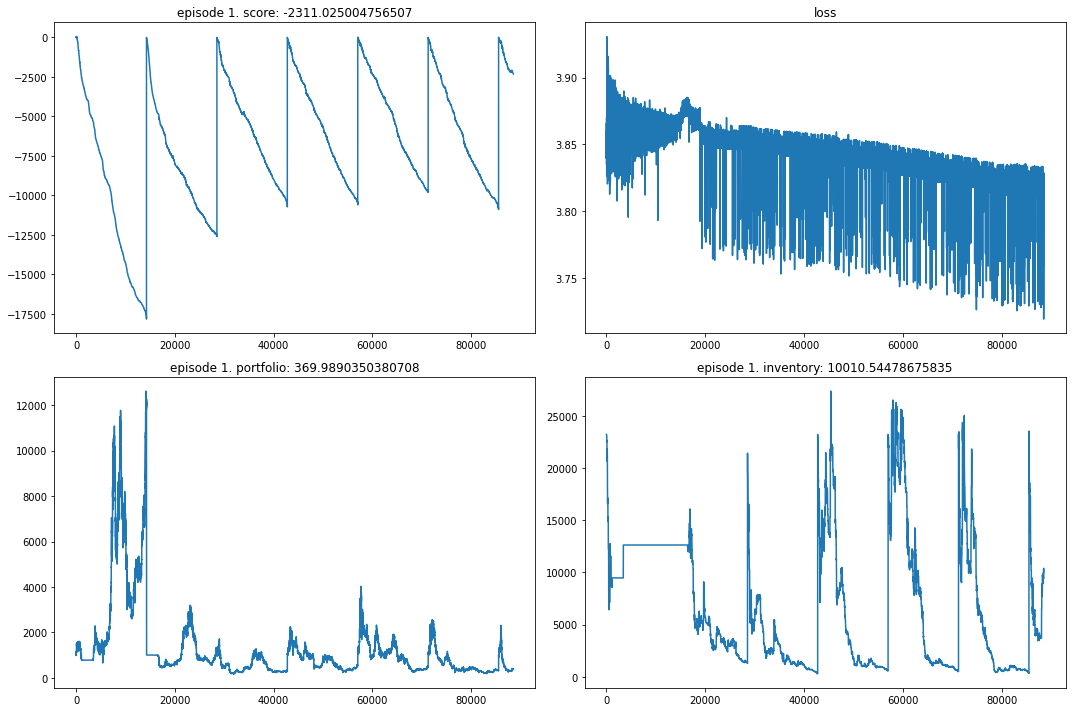

Training:  22%|██▏       | 3092/14258 [28:23<1:53:59,  1.63it/s, loss=3.82, Portfolio=308, Inventory=7.58e+3]

In [ ]:
i = 0
max_inventory: float = 1
while i < 100:
    i+=1
    agent.train()
    agent._plot_all()
    scores, losses, portfolio, inventory = agent.get_plot_data()
    if max(inventory) >= max_inventory:
        max_inventory = max(inventory)
        now = datetime.now()
        timestamp = now.strftime("%d-%m-%Y-%H-%M")
        filename = "TCN_agent_"+str(timestamp)+"max_inv="+str(max_inventory)+".pkl"
        agent.save_model(filename="TCN_agent_"+str(timestamp)+"max_inv="+str(max_inventory)+".pth")
        # with open(filename, "wb") as file:
        #     pickle.dump(agent, file, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
scores, losses, portfolio, inventory = agent.get_plot_data()
now = datetime.now()
timestamp = now.strftime("%d-%m-%Y-%H-%M")
filename = "TCNx6v1_agent_"+str(timestamp)+"max_inv="+str(max(inventory))+".pkl"
agent.save_model(filename="TCNx6v1_agent_"+str(timestamp)+"max_inv="+str(max(inventory))+"min_loss="+str(min(losses))+".pth",memory_fn=timestamp)
# with open(filename, "wb") as file:
#     pickle.dump(agent, file, protocol=pickle.HIGHEST_PROTOCOL)

## Test

Run the trained agent (1 episode).

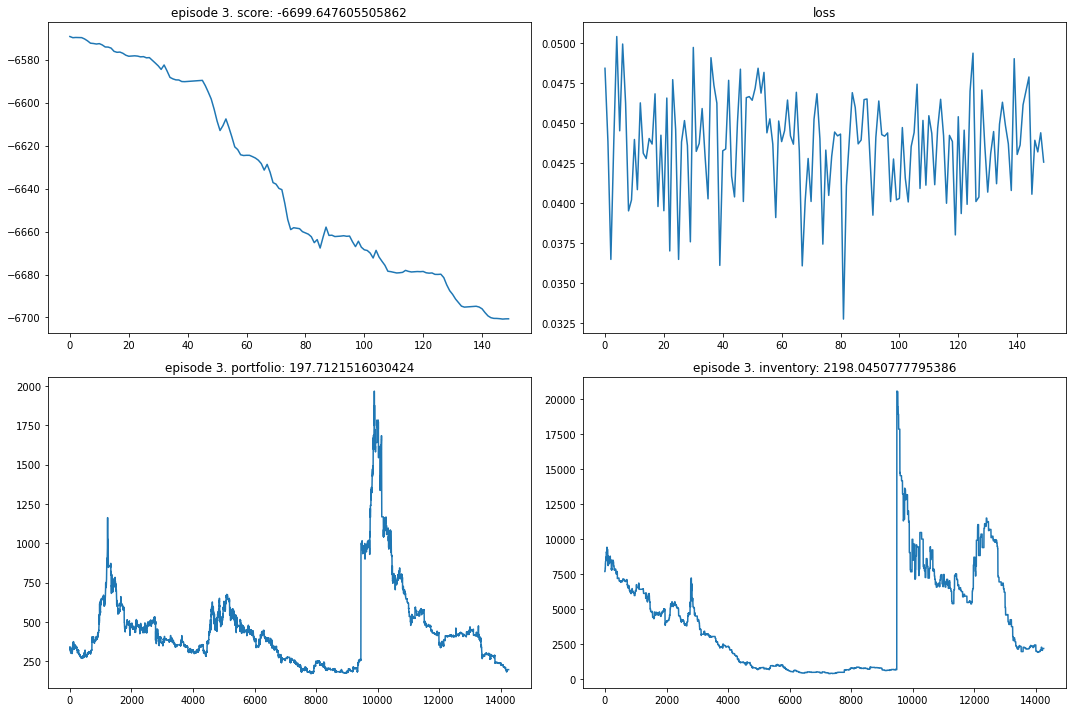

Testing:  34%|███▍      | 4867/14258 [05:08<09:55, 15.78it/s, Score=-67.4, Portfolio=204, Inventory=2.42e+3]


KeyboardInterrupt: 

In [ ]:
agent.test()

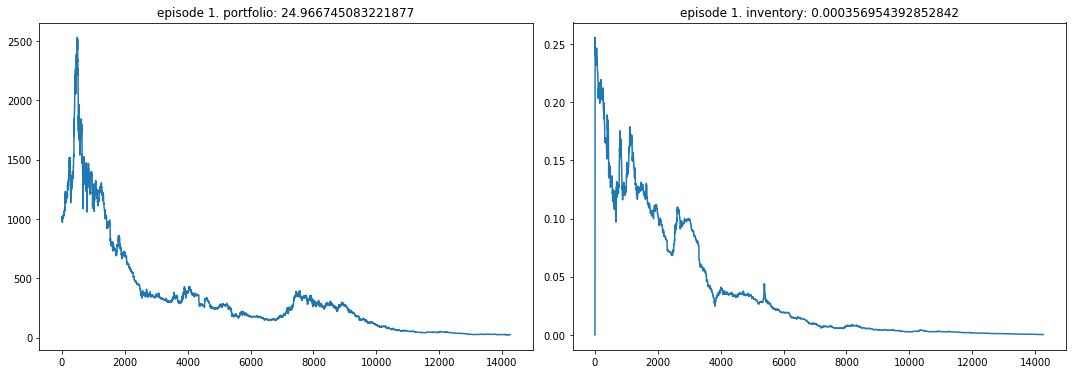

In [ ]:
agent._plot_all()

In [ ]:
agent.clear_plot_history()

In [ ]:

agent.inventory = []
agent.portfolio = []
agent.losses = []
agent.scores = []

In [ ]:
TCN_dict = {}
for key, value in agent.dqn.state_dict().items():
    if key.startswith("tcn"):
        new_key = key.replace("tcn.", "")  # Remove the "Convolution_1." prefix
        TCN_dict[new_key] = value

# Conv2_dict = {}  # Create a separate dictionary for bottleneck
# for key, value in agent.dqn.state_dict().items():
#     if key.startswith("Convolution_2"):
#         new_key = key.replace("Convolution_2.", "")  # Remove the "bottleneck." prefix
#         Conv2_dict[new_key] = value

# Conv3_dict = {}  # Create a separate dictionary for bottleneck
# for key, value in agent.dqn.state_dict().items():
#     if key.startswith("Convolution_3"):
#         new_key = key.replace("Convolution_3.", "")  # Remove the "bottleneck." prefix
#         Conv3_dict[new_key] = value

# Conv4_dict = {}  # Create a separate dictionary for bottleneck
# for key, value in agent.dqn.state_dict().items():
#     if key.startswith("Convolution_4"):
#         new_key = key.replace("Convolution_4.", "")  # Remove the "bottleneck." prefix
#         Conv4_dict[new_key] = value

# Conv5_dict = {}  # Create a separate dictionary for bottleneck
# for key, value in agent.dqn.state_dict().items():
#     if key.startswith("Convolution_5"):
#         new_key = key.replace("Convolution_5.", "")  # Remove the "bottleneck." prefix
#         Conv5_dict[new_key] = value


# networks: dqn, dqn_target
obs_dim = agent.env.observation_space.shape
action_dim = agent.env.action_space.n
agent.dqn = Fine_tune_1(
            obs_dim[1], action_dim, agent.atom_size, agent.support
        ).to(agent.device)

agent.dqn_target = Fine_tune_1(
            obs_dim[1], action_dim, agent.atom_size, agent.support
        ).to(agent.device)

# Load pretrained weights for Convolution_1
agent.dqn.tcn.load_state_dict(TCN_dict)
# Freeze Convolution_1 parameters
for param in agent.dqn.tcn.parameters():
    param.requires_grad = False

# # Load pretrained weights for Convolution_2
# agent.dqn.Convolution_2.load_state_dict(Conv2_dict)
# # Freeze bottleneck parameters
# for param in agent.dqn.Convolution_2.parameters():
#     param.requires_grad = False

# # Load pretrained weights for Convolution_3
# agent.dqn.Convolution_3.load_state_dict(Conv3_dict)
# # Freeze bottleneck parameters
# for param in agent.dqn.Convolution_3.parameters():
#     param.requires_grad = False

# # Load pretrained weights for Convolution_4
# agent.dqn.Convolution_4.load_state_dict(Conv4_dict)
# # Freeze bottleneck parameters
# for param in agent.dqn.Convolution_4.parameters():
#     param.requires_grad = False

# # Load pretrained weights for Convolution_5
# agent.dqn.Convolution_5.load_state_dict(Conv5_dict)
# # Freeze bottleneck parameters
# for param in agent.dqn.Convolution_5.parameters():
#     param.requires_grad = False

# Load dqn_target
agent.dqn_target.load_state_dict(agent.dqn.state_dict())
agent.dqn_target.eval()


Fine_tune_1(
  (tcn): TCN(
    (downsample_skip_connection): ModuleList(
      (0): Conv1d(64, 512, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 512, kernel_size=(1,), stride=(1,))
      (2): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
      (3): None
      (4): None
      (5): None
    )
    (activation_skip_out): ReLU()
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): CausalConv1d(33, 64, kernel_size=(24,), stride=(1,))
        (conv2): CausalConv1d(64, 64, kernel_size=(24,), stride=(1,))
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
        (downsample): Conv1d(33, 64, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
        (conv1): CausalConv1d(64, 128, kernel_size=(24,), stride=(1,), dilation=(2,))
        (conv2): CausalConv1d(128, 128, kernel_size=(24,), stride=(1,), dilation=(2,))


In [ ]:

scores, losses, portfolio, inventory = agent.get_plot_data()
now = datetime.now()
timestamp = now.strftime("%d-%m-%Y-%H-%M")
filename = "TCNx3v2_agent_"+str(timestamp)+"NEW"+".pkl"
agent.save_model(filename="TCNx3v2_agent_"+str(timestamp)+"NEW_"+".pth",memory_fn=timestamp)
# with open(filename, "wb") as file:
#     pickle.dump(agent, file, protocol=pickle.HIGHEST_PROTOCOL)